# Introduction
This notebook compares the baseline model and the LigthGBM (Light Gradient Boosting Machine) model performance to predict total daily energy demand in Saskatchewan. 
Each model is trained and tested using the cross-validation. The models’ performances are evaluated using metrics, such as Mean Squared Error (MSE), Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), Median Absolute Percentage Error (MdAPE), and R-squared and the results are stored for each fold in the cross-validation. Finally, the performance of all models are compared, conclusions are drawn based on the evaluation metrics, and the best model is utilize for predictions using the testing dataset.

# Load Data
Forecasting daily natural gas consumption accurately is difficult because it is affected by various factors. The dataset is the historical daily natural gas demand in energy unit (TJ/d) and the weather data in Saskatchewan from November 1, 2013 to October 31, 2023. This dataset has be preprocessed and explored in the "cleaning_EDA.ipynb" notebook and is fit for model development. 

In [2]:
# Importing the necessary libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Importing libraries for modules
from lightgbm import LGBMRegressor
import lightgbm as lgb

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pickle
from joblib import load
import warnings 
warnings.filterwarnings('ignore')

In [3]:
# Import the merged dataset (Natural Gas demand and Weather factors)
merged_df = pd.read_csv('../data/merged_data.csv')
merged_df.head()

,DATE,NG_DEMAND,LOWEST_REL_HUMIDITY,HIGHEST_REL_HUMIDITY,HEATING_DEGREE_DAYS,COOLING_DEGREE_DAYS,TOTAL_PRECIPITATION,LOWEST_TEMPERATURE,AVG_TEMPERATURE,HIGHEST_TEMPERATURE,DIRECTION_MAX_GUST,SPEED_MAX_GUST
0,2013-11-01,617,44.400000,80.333333,14.833333,0.0,0.140000,-2.933333,3.166667,9.206667,28.066667,40.600000
1,2013-11-02,630,34.133333,73.066667,16.293333,0.0,0.226667,-5.866667,1.706667,9.266667,8.400000,25.400000
2,2013-11-03,688,60.133333,81.600000,16.726667,0.0,5.806667,-2.166667,1.273333,4.706667,24.400000,55.000000
3,2013-11-04,815,66.466667,79.133333,23.540000,0.0,0.900000,-9.106667,-5.540000,-1.906667,31.466667,56.933333
4,2013-11-05,789,53.000000,71.666667,27.820000,0.0,0.040000,-14.966667,-9.820000,-4.633333,15.800000,21.600000


# Data Preparation for Modelling 

First, we split the dataset into two parts: a balanced set, called “learning dataset (85%) 
and an “independent test se (15%), and then the learning dataset is further subdivided into training set 850%) and validation sets (15%) to train and validate the models, respectively. 

- The Training Set: It is the set of data that is used to train and make the model learn the hidden features/patterns in the data.
- The Validation Set: The validation set is a set of data, separate from the training set, that is used to validate our model performance during training. 
This validation process gives information that helps us tune the model’s hyperparameters and configurations accordingly. It is like a critic telling us whether the training is moving in the right direction or no
- The Test Set: The test set is a separate set of data used to test the model after completing the training. 
It provides an unbiased final model performance metric in terms of accuracy, precision, etc. To put it simply, it answers the question of "H well does the model perform?"?"t.”.lds

In [4]:
# Split the data into training set from 2013-11-01 to 2021-10-31, and using 2021-11-01 to 2023-10-31 as test/validation set
learning_data_df = merged_df[merged_df['DATE'] < '2022-05-01']
testing_data_df = merged_df[merged_df['DATE'] >= '2022-05-01']

# Print the shape of the train-test split
print(learning_data_df.shape)
print(testing_data_df.shape)

(3103, 12)
(549, 12)


# Model Building
In this project, the recommended models to be utilized are Prophet, LightGBM, SARIMAX, LSTM, Hybrid Prophet-LGBM, and Hybrid Prophet-LSTM.

## 1. Baseline Model
In every modeling process, there needs to be a baseline model whose results can be used to assess our primary ones. In our case, we chose to use a Linear Regression model because of its simplicity and efficiency.

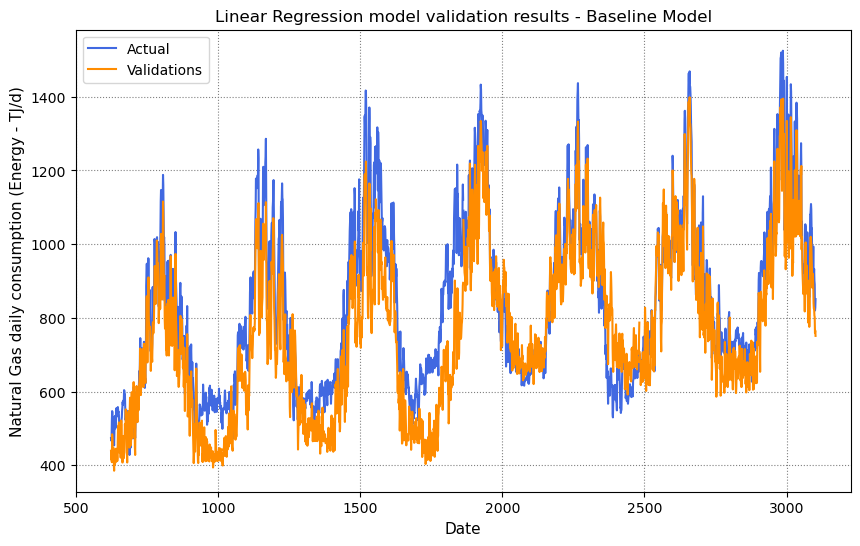


Average Validation Metrics across all Folds:
Mean Squared Error: 12113.538
Mean Absolute Error: 90.061
Root Mean Squared Error: 104.681
Mean Absolute Percentage Error: 11.254%
Median Absolute Percentage Error: 10.350%
R-squared: 0.732


In [5]:
# Split the learning dataset to training and validation sets
learning_df = learning_data_df.copy()

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4)  # You can adjust the number of splits

# Create a function to calculate evaluation metrics
def calculate_metrics(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    mdape = np.median(np.abs((true_values - predicted_values) / true_values)) * 100
    r2 = r2_score(true_values, predicted_values)

    return mse, mae, rmse, mape, mdape, r2

# Create a Linear Regression object
lr = LinearRegression()

# Use the learning_df for training and testing
X = learning_df.drop(['DATE', 'NG_DEMAND'], axis=1)
y = learning_df['NG_DEMAND']

base_metrics = []
plt.figure(figsize=(10, 6))

# Apply Time Series Cross-Validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    lr.fit(X_train, y_train)

    # Make predictions on the test set
    validations = lr.predict(X_test)

    # Calculate the mean squared error of the predictions
    mse, mae, rmse, mape, mdape, r2 = calculate_metrics(y_test, validations)
    base_metrics.append((mse, mae, rmse, mape, mdape, r2))

    # Convert the Date to datetime
    learning_df['DATE'] = pd.to_datetime(learning_df['DATE'])

    # Plot actual vs. forecast values
    plt.plot(X_test.index, y_test, label='Actual', color='royalblue')
    plt.plot(X_test.index, validations, label='Validations', color='darkorange')
    
plt.title('Linear Regression model validation results - Baseline Model', fontsize=12)
plt.xlabel('Date', fontsize=11)
plt.ylabel('Natural Gas daily consumption (Energy - TJ/d)', fontsize=11)
# Only add the legend once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.grid(linestyle=":", color='grey')
plt.show()

avg_baseline_metrics = np.mean(base_metrics, axis=0)
print("\nAverage Validation Metrics across all Folds:")
print(f"Mean Squared Error: {avg_baseline_metrics[0]:.3f}")
print(f"Mean Absolute Error: {avg_baseline_metrics[1]:.3f}")
print(f"Root Mean Squared Error: {avg_baseline_metrics[2]:.3f}")
print(f"Mean Absolute Percentage Error: {avg_baseline_metrics[3]:.3f}%")
print(f"Median Absolute Percentage Error: {avg_baseline_metrics[4]:.3f}%")
print(f"R-squared: {avg_baseline_metrics[5]:.3f}")

## 2. LightGBM (Light Gradient Boosting Machine)

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:
- Faster training speed and higher efficiency
- Lower memory usage
- Better accuracy
- Support of parallel and GPU learning
- Capable of handling large_scale datae dat

Benefiting from these advantages, LightGBM is being widely-used in many winning solutions of machine learning competitions.

Comparison experiments on public datasets show that LightGBM can outperform existing boosting frameworks on both efficiency and accuracy, with significantly lower memory consumption. What's more, distributed learning experiments show that LightGBM can achieve a linear speed-up by using multiple machines for training in specific settings.a

### 2.2 LightGBM Cross-Validation 
This method of data split is implemented on the learning dataset, which split the data into training and validation sets to evaluate the performance of LSTM model.
- 
The number of folds is set to 4, meaning the time series data is split into four consecutive segments for cross-validatio
- .
In each foldof the cross-validation, the learning data is divided into two parts: a training set and a validation s
- t.
The training set contains past observations, and the validation set contains future observations. This mimics a real-world scenario where the model is trained on historical data and tested on more recent d
- ta.
One key characteristics of time series cross-validation is that the data is split sequentially. Each fold uses a different portion of the time series data for validation, with the training set always preceding the validation set. This ensures that the model is evaluated on unseen data that comes after the training ta.d.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1495
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 10
[LightGBM] [Info] Start training from score 685.335474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

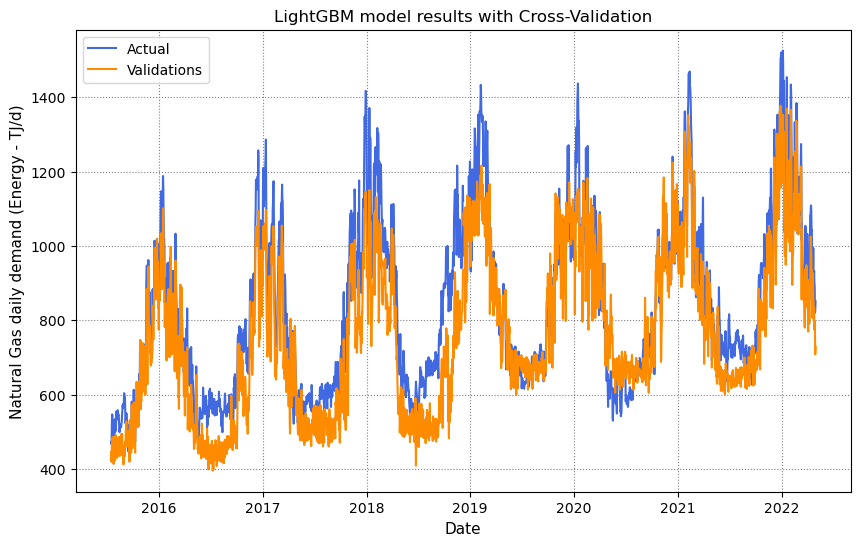


Average Metrics across all Folds:
Validation Mean Squared Error: 12428.226
Validation Mean Absolute Error: 90.289
Validation Root Mean Squared Error: 108.329
Validation Mean Absolute Percentage Error: 10.967%
Validation Median Absolute Percentage Error: 10.307%
Validation R-squared: 0.726


In [6]:
# Define the wrapper class for the LightGBM model
class LGBMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100):
        self.num_leaves = num_leaves
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.model = None

    def fit(self, X, y=None):
        self.model = lgb.LGBMRegressor(num_leaves=self.num_leaves, max_depth=self.max_depth, 
                                       learning_rate=self.learning_rate, n_estimators=self.n_estimators)
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

# Function to calculate evaluation metrics
def calculate_metrics(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    mdape = np.median(np.abs((true_values - predicted_values) / true_values)) * 100
    r2 = r2_score(true_values, predicted_values)

    return mse, mae, rmse, mape, mdape, r2

# Load the data
df = learning_data_df.copy()
df['DATE'] = pd.to_datetime(df['DATE'])

# Prepare the features and target
X = df.drop(['DATE', 'NG_DEMAND'], axis=1)
y = df['NG_DEMAND']

# Initialize the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4)

# Initialize the model
model = LGBMWrapper()

# Initialize the plot
plt.figure(figsize=(10, 6))

predictions = []
cv_fold_metrics = []

# Perform cross-validation
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    # Split the data into training and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model on the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    predictions = model.predict(X_test)
    
    # Calculate and store performance metrics for this fold
    mse, mae, rmse, mape, mdape, r2 = calculate_metrics(y_test, predictions)
    cv_fold_metrics.append([mse, mae, rmse, mape, mdape, r2])

    # Print the metrics for this fold
    print(f"Fold {i + 1} Metrics:")
    print(f"MSE: {mse:.3f}, MAE: {mae:.3f}, RMSE: {rmse:.3f}, MAPE: {mape:.3f}%, MdAPE: {mdape:.3f}%, R-squared: {r2:.3f}")
    
    # Plot the test data and predictions for this fold
    plt.plot(df.iloc[test_index]['DATE'], y_test, color='royalblue', label='Actual')
    plt.plot(df.iloc[test_index]['DATE'], predictions, color='darkorange', label='Validations')

# Show the plot with a legend
plt.title('LightGBM model results with Cross-Validation', fontsize=12)
plt.xlabel('Date', fontsize=11)
plt.ylabel('Natural Gas daily demand (Energy - TJ/d)', fontsize=11)
# Only add the legend once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.grid(linestyle=":", color='grey')
plt.show()

# Calculate and print the average evaluation metrics across all folds
average_cv_metrics = np.mean(cv_fold_metrics, axis=0)
print("\nAverage Metrics across all Folds:")
print(f"Validation Mean Squared Error: {average_cv_metrics[0]:.3f}")
print(f"Validation Mean Absolute Error: {average_cv_metrics[1]:.3f}")
print(f"Validation Root Mean Squared Error: {average_cv_metrics[2]:.3f}")
print(f"Validation Mean Absolute Percentage Error: {average_cv_metrics[3]:.3f}%")
print(f"Validation Median Absolute Percentage Error: {average_cv_metrics[4]:.3f}%")
print(f"Validation R-squared: {average_cv_metrics[5]:.3f}")


### 2.3 LightGBM Hyperparameter Tuning
This hyperparameter tuning process uses random search to optimize the LightGBM model. The parameters being tuned include the number of leaves, maximum depth, learning rate, number of estimators, boosting type, subsample ratio, column sample by tree, and regularization parameters alpha and lambda. By exploring different combinations of these parameters, the model aims to improve its predictive performance and increase the R-squared value

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

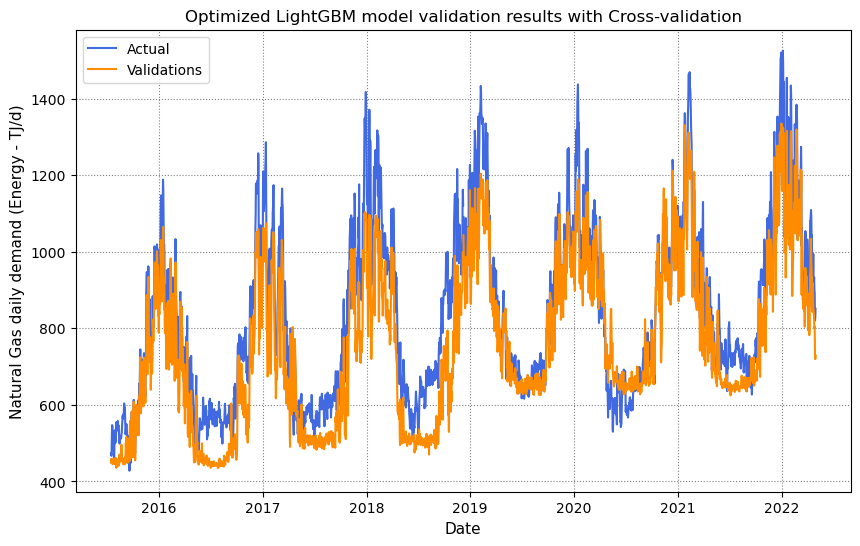


Average Metrics Across All Folds:
Validation Mean Squared Error: 11280.217
Validation Mean Absolute Error: 88.254
Validation Root Mean Squared Error: 103.111
Validation Mean Absolute Percentage Error: 10.737%
Validation Median Absolute Percentage Error: 10.376%
Validation R-squared: 0.749


In [7]:
# Load the data
df_hyp = learning_data_df.copy()
df_hyp['DATE'] = pd.to_datetime(df_hyp['DATE'])

# Prepare the features and target
X = df_hyp.drop(['DATE', 'NG_DEMAND'], axis=1)
y = df_hyp['NG_DEMAND']

# Define a wrapper class for the LightGBM model
class LGBMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, boosting_type='gbdt', 
                 colsample_bytree=1.0, subsample=1.0, reg_alpha=0.0, reg_lambda=0.0, min_child_samples=20, force_col_wise=True, verbose=0):
        self.num_leaves = num_leaves
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.boosting_type = boosting_type
        self.colsample_bytree = colsample_bytree
        self.subsample = subsample
        self.reg_alpha = reg_alpha
        self.reg_lambda = reg_lambda
        self.min_child_samples = min_child_samples
        self.force_col_wise = force_col_wise
        self.verbose = verbose
        self.model = None

    def fit(self, X, y=None):
        self.model = lgb.LGBMRegressor(num_leaves=self.num_leaves, max_depth=self.max_depth, learning_rate=self.learning_rate, n_estimators=self.n_estimators,
            boosting_type=self.boosting_type, colsample_bytree=self.colsample_bytree, subsample=self.subsample, reg_alpha=self.reg_alpha, reg_lambda=self.reg_lambda, 
            min_child_samples=self.min_child_samples, force_col_wise=self.force_col_wise, verbose=self.verbose
        )
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

                              
# Function to calculate evaluation metrics
def calculate_metrics(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    mdape = np.median(np.abs((true_values - predicted_values) / true_values)) * 100
    r2 = r2_score(true_values, predicted_values)

    return mse, mae, rmse, mape, mdape, r2
    
# Instantiate the LGBMWrapper class
model = LGBMWrapper()

# Define the parameter grid for hyperparameter tuning
param_dist = {
    'num_leaves': [2**i for i in range(3, 8)],  # num_leaves for max_depth in [3, 7]
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'subsample': [0.5, 0.7, 0.9],
    'reg_alpha': [0.1, 0.5, 1],
    'reg_lambda': [0.1, 0.5, 1],
    'min_child_samples': [10, 20, 30],
}

# Initialize the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4)

# Perform GridSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(model, param_distributions=param_dist, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1, verbose=0, n_iter=200)
random_search.fit(X, y) 

# Get the best hyperparameters
best_params = random_search.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)

# Instantiate the LGBMWrapper class with the best hyperparameters
best_model = LGBMWrapper(**best_params)

# Initialize the plot
plt.figure(figsize=(10, 6))

validations = []
hyp_fold_metrics = []

# Perform cross-validation
for i, (train_index, validation_index) in enumerate(tscv.split(X)):
    # Split the data into training and test sets for this fold
    X_train, X_validation = X.iloc[train_index], X.iloc[validation_index]
    y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]
    
    # Train the model on the training data and making validation
    best_model.fit(X_train, y_train)
    validations = best_model.predict(X_validation)

    # Save the best_model to a file using pickle
    with open('../models/best_lightgbm_model.pkl', 'wb') as model_file:
        pickle.dump(best_model, model_file)

    # unpickle the model
    with open('../models/best_lightgbm_model.pkl', 'rb') as model_file:
        loaded_model = pickle.load(model_file)
    
    validation_mse, validation_mae, validation_rmse, validation_mape, validation_mdape, validation_r2 = calculate_metrics(y_validation, validations)
    hyp_fold_metrics.append([validation_mse, validation_mae, validation_rmse, validation_mape, validation_mdape, validation_r2])

    print(f"Fold {i + 1} Metrics:")
    print(f"MSE: {validation_mse:.3f}, MAE: {validation_mae:.3f}, RMSE: {validation_rmse:.3f}, MAPE: {validation_mape:.3f}%, MdAPE: {validation_mdape:.3f}%, R-squared: {validation_r2:.3f}")
    
    # Plot the test data and predictions
    plt.plot(df.iloc[validation_index]['DATE'], y_validation, color='royalblue', label='Actual')
    plt.plot(df.iloc[validation_index]['DATE'], validations, color='darkorange', label='Validations')

# Show the plot with a legend
plt.title('Optimized LightGBM model validation results with Cross-validation', fontsize=12)
plt.xlabel('Date', fontsize=11)
plt.ylabel('Natural Gas daily demand (Energy - TJ/d)', fontsize=11)
# Only add the legend once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.grid(linestyle=":", color='grey')
plt.show()

# Calculate and print the average evaluation metrics across all folds
average_optimized_metrics = np.mean(hyp_fold_metrics, axis=0)
print("\nAverage Metrics Across All Folds:")
print(f"Validation Mean Squared Error: {average_optimized_metrics[0]:.3f}")
print(f"Validation Mean Absolute Error: {average_optimized_metrics[1]:.3f}")
print(f"Validation Root Mean Squared Error: {average_optimized_metrics[2]:.3f}")
print(f"Validation Mean Absolute Percentage Error: {average_optimized_metrics[3]:.3f}%")
print(f"Validation Median Absolute Percentage Error: {average_optimized_metrics[4]:.3f}%")
print(f"Validation R-squared: {average_optimized_metrics[5]:.3f}")


### 2.4 LightGBM Models Validation Performance

In [9]:
# Accessing individual metrics for Baseline model with cross-validation 
mse_baseline_cv = avg_baseline_metrics[0]
mae_baseline_cv= avg_baseline_metrics[1]
rmse_baseline_cv = avg_baseline_metrics[2]
mape_baseline_cv = avg_baseline_metrics[3]
mdape_baseline_cv = avg_baseline_metrics[4]
r2_baseline_cv = avg_baseline_metrics[5]

# Accessing individual metrics for LGBM cross-validation model
average_cv_metrics = np.mean(cv_fold_metrics, axis=0)
mse_lgbm_cv = average_cv_metrics[0]
mae_lgbm_cv= average_cv_metrics[1]
rmse_lgbm_cv = average_cv_metrics[2]
mape_lgbm_cv = average_cv_metrics[3]
mdape_lgbm_cv = average_cv_metrics[4]
r2_lgbm_cv = average_cv_metrics[5]

# Accessing individual metrics for Optimized LGBM model with cross-validation 
mse_lgbm_hy = average_optimized_metrics[0]
mae_lgbm_hy= average_optimized_metrics[1]
rmse_lgbm_hy = average_optimized_metrics[2]
mape_lgbm_hy = average_optimized_metrics[3]
mdape_lgbm_hy = average_optimized_metrics[4]
r2_lgbm_hy = average_optimized_metrics[5]

# Define the metrics for the model
metrics_base_model = [mse_baseline_cv, mae_baseline_cv, rmse_baseline_cv, mape_baseline_cv, mdape_baseline_cv, r2_baseline_cv]
metrics_lgbm_cv = [mse_lgbm_cv, rmse_lgbm_cv, mape_lgbm_cv, mae_lgbm_cv, mdape_lgbm_cv, r2_lgbm_cv]
metrics_lgbm_hy = [mse_lgbm_hy, rmse_lgbm_hy, mape_lgbm_hy, mae_lgbm_hy, mdape_lgbm_hy, r2_lgbm_hy]

# Define the labels for the metrics
labels = ['MSE', 'RMSE', 'MAPE', 'MAE', 'MDAPE', 'R-squared']

# Create a DataFrame to store the metrics
df_metrics_lgbm = pd.DataFrame({'Baseline Model': metrics_base_model, 'LightGBM with Cross-validation': metrics_lgbm_cv, 'Optimized LightGBM': metrics_lgbm_hy}, index=labels)

# Transpose the DataFrame
df_metrics_lgbm = df_metrics_lgbm.transpose()

#df_metrics_lgbm = df_metrics_lgbm.applymap(lambda x: f'{x: .3}')
df_metrics_lgbm.head(10)

,MSE,RMSE,MAPE,MAE,MDAPE,R-squared
Baseline Model,12113.538360,90.061312,104.681160,11.254453,10.350113,0.731666
LightGBM with Cross-validation,12428.226448,108.328562,10.966833,90.288928,10.307380,0.725686
Optimized LightGBM,11280.217003,103.110832,10.736667,88.253947,10.376453,0.748924


- The LightGBM model was trained and evaluated using the cross-validation, and an Improved version which involved hyperparameter tuning.
- The cross-validation method resulted in the highest error Mean Squared Error (MSE) of 12428 and the lowest R-squared value of 0.72, indicating the worest performance among the three. However, the hyperparameter-tuned Improved LightGBM model showed a slightly better performance in terms of Mean Absolute Percentage Error (MAPE), Mean Absolute Error (MAE), and Median Absolute Percentage Error (MDAPE) compared to the standard Cross-validation method.
- Despite these improvements, the R-squared value remained the same for both Cross-validation and Improved methods, suggesting similar overall predictive power.

### 3.5 LightGBM Model Testing Evaluation

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.

Prediction Performance Metrics for the Testing Dataset:
Test Mean Absolute Error: 108.222
Test Mean Squared Error: 14269.284
Test Root Mean Squared Error: 119.454
Test R-squared: 0.661
Test Mean Absolute Percentage Error: 12.133%
Test Median Absolute Percentage Error: 11.483%


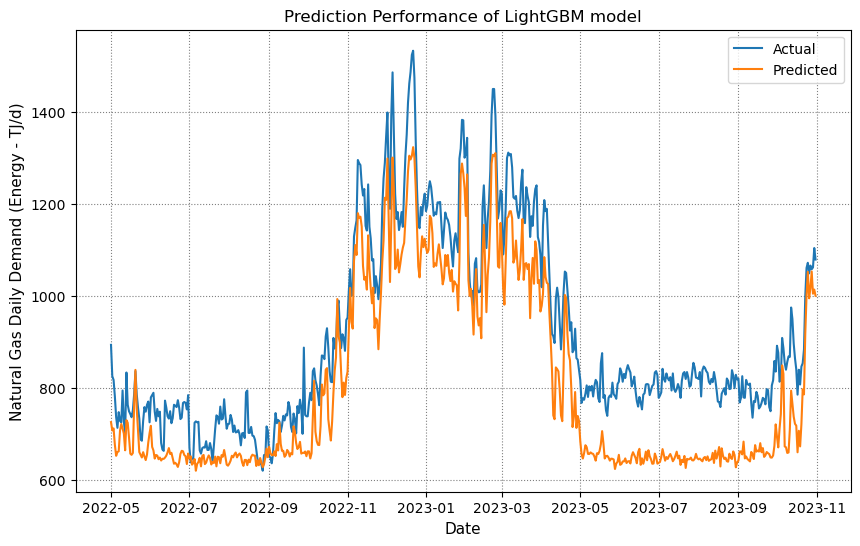

In [10]:
# Load the the testing data
testing_df = testing_data_df.copy()
testing_df['DATE'] = pd.to_datetime(testing_df['DATE'])

# Prepare the features and target
X_test = testing_df.drop(['DATE', 'NG_DEMAND'], axis=1)
y_test = testing_df['NG_DEMAND']

y_pred = loaded_model.predict(X_test)

# Calculate performance metrics for the test set
mae_test = mean_absolute_error(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred)
mape_test = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mdape_test = np.median(np.abs((y_test - y_pred) / y_test)) * 100

# Print prediction performance metrics
print("\nPrediction Performance Metrics for the Testing Dataset:")
print(f'Test Mean Absolute Error: {mae_test:.3f}')
print(f'Test Mean Squared Error: {mse_test:.3f}')
print(f'Test Root Mean Squared Error: {rmse_test:.3f}')
print(f'Test R-squared: {r2_test:.3f}')
print(f'Test Mean Absolute Percentage Error: {mape_test:.3f}%')
print(f'Test Median Absolute Percentage Error: {mdape_test:.3f}%')

# Convert the Date to datetime
#testing_set_df['DATE'] = pd.to_datetime(testing_set_df['DATE'])

# Plotting actuals and forecasted values for the test set
plt.figure(figsize=(10, 6))
plt.plot(testing_df['DATE'], y_test, label='Actual')
plt.plot(testing_df['DATE'], y_pred, label='Predicted')
plt.legend()
plt.xlabel('Date', fontsize=11)
plt.ylabel('Natural Gas Daily Demand (Energy - TJ/d)', fontsize=11)
plt.grid(linestyle=":", color='grey')
plt.title('Prediction Performance of LightGBM model', fontsize=12)
plt.show()

lightgbm_results_df = testing_df[['DATE', 'NG_DEMAND']].copy()
lightgbm_results_df['Predicted_NG_DEMAND'] = y_pred

In [11]:
# Save the prediction result dataframe
lightgbm_results_df.reset_index(drop=True, inplace=True)
lightgbm_results_df.to_csv('../data/lightgbm_prediction.csv', index=False)
lightgbm_results_df.head()

,DATE,NG_DEMAND,Predicted_NG_DEMAND
0,2022-05-01,894,726.406121
1,2022-05-02,826,708.367329
2,2022-05-03,818,712.784014
3,2022-05-04,782,677.040199
4,2022-05-05,737,653.258938


In [12]:
# Define the metrics for the predicted model
lightgbm_prediction_metrics = [mse_test, rmse_test, mape_test, mae_test, mdape_test, r2_test]

# Define the labels for the metrics
labels = ['MSE', 'RMSE', 'MAPE', 'MAE', 'MDAPE', 'R-squared']

# Create a DataFrame to store the metrics
df_lightgbm_pred = pd.DataFrame({'LightGBM Model Prediction': lightgbm_prediction_metrics}, index=labels)

# Transpose the DataFrame
df_lightgbm_pred = df_lightgbm_pred.transpose()

# Save the DataFrame to a CSV file
df_lightgbm_pred.to_csv('../data/lightgbm_predictions_metrics.csv', index=False)
df_lightgbm_pred.head()

,MSE,RMSE,MAPE,MAE,MDAPE,R-squared
LightGBM Model Prediction,14269.283544,119.454106,12.132852,108.222045,11.483491,0.660901
